[INFO] loading images...


C:\Users\sunshine\anaconda3\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 135s 1s/step - loss: 0.6058 - accuracy: 0.7091 - val_loss: 0.1517 - val_accuracy: 0.9870
Epoch 2/20
95/95 [==============================] - 90s 943ms/step - loss: 0.1785 - accuracy: 0.9655 - val_loss: 0.0759 - val_accuracy: 0.9870
Epoch 3/20
95/95 [==============================] - 95s 1s/step - loss: 0.0999 - accuracy: 0.9744 - val_loss: 0.0516 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 94s 994ms/step - loss: 0.0792 - accuracy: 0.9784 - val_loss: 0.0422 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 93s 981ms/step - loss: 0.0698 - accuracy: 0.9803 - val_loss: 0.0378 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 95s 998ms/step - loss: 0.0486 - accuracy: 0.9867 - val_loss: 0.0348 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 97s 1s/step - loss: 0.0496 - accuracy: 0.9847

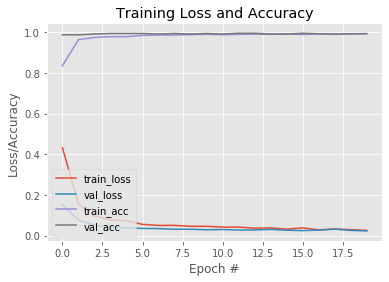

In [1]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4 
EPOCHS = 20 
BS = 32 

DIRECTORY = r"C:\Users\sunshine\Downloads\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]    


print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image) 

    	data.append(image)
    	labels.append(category)


lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)  

data = np.array(data, dtype="float32")
labels = np.array(labels) 
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
                
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")



baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)



for layer in baseModel.layers:
	layer.trainable = False


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")